# Guided Project: Building a Spam Filter with Naive Bayes

Solution notebook can be referenced [here](https://github.com/dataquestio/solutions/blob/master/Mission433Solutions.ipynb).

## Exploring the Dataset

In this guided project, we're going to study the practical side of the algorithm by building a spam filter for SMS messages.

To classify messages as spam or non-spam, we saw in the previous lesson that the computer:

1. Learns how humans classify messages.
2. Uses that human knowledge to estimate probabilities for new messages — probabilities for spam and non-spam.
3. Classifies a new message based on these probability values — if the probability for spam is greater, then it classifies the message as spam. Otherwise, it classifies it as non-spam (if the two probability values are equal, then we may need a human to classify the message).

So our first task is to "teach" the computer how to classify messages. To do that, we'll use the multinomial Naive Bayes algorithm along with a dataset of 5,572 SMS messages that are already classified by humans.

The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from the [The UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection). You can also download the dataset directly from this [link](https://dq-content.s3.amazonaws.com/433/SMSSpamCollection). The data collection process is described in more details on [this page](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/#composition), where you can also find some of the authors' papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sms_spam_collection = pd.read_csv('SMSSpamCollection', delimiter='\t', header=None, names=['Label', 'SMS'])
sms_spam_collection.head()
# ham is the label for non-spam SMS

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
sms_spam_collection.shape

(5572, 2)

In [4]:
sms_spam_collection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
Label    5572 non-null object
SMS      5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


In [5]:
percentages_of_class = sms_spam_collection['Label'].value_counts(normalize = True)*100
percentages_of_class

ham     86.593683
spam    13.406317
Name: Label, dtype: float64

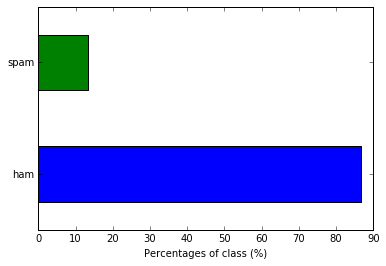

In [6]:
% matplotlib inline
percentages_of_class.plot.barh()
plt.xlabel('Percentages of class (%)')

##  Training and Test Set

We're going to keep 80% of our dataset for training, and 20% for testing (we want to train the algorithm on as much data as possible, but we also want to have enough test data). The dataset has 5,572 messages, which means that:

- The training set will have 4,458 messages (about 80% of the dataset).
- The test set will have 1,114 messages (about 20% of the dataset).

To better understand the purpose of putting a test set aside, let's begin by observing that all 1,114 messages in our test set are already classified by a human. When the spam filter is ready, we're going to treat these messages as new and have the filter classify them. Once we have the results, we'll be able to compare the algorithm classification with that done by a human, and this way we'll see how good the spam filter really is.

For this project, our goal is to create a spam filter that classifies new messages with an ***accuracy greater than 80%*** — so we expect that more than 80% of the new messages will be classified correctly as spam or ham (non-spam).

In [7]:
# Start by shuffling the dataset
sms_spam_collection = sms_spam_collection.sample(frac=1, random_state=1)
sms_spam_collection.head()

,Label,SMS
1078,ham,"Yep, by the pretty sculpture"
4028,ham,"Yes, princess. Are you going to make me moan?"
958,ham,Welp apparently he retired
4642,ham,Havent.
4674,ham,I forgot 2 ask ü all smth.. There's a card on ...


In [8]:
# use a 80/20 train/test split

train_size = round(sms_spam_collection.shape[0]*0.8)
train_size

4458

In [9]:
sms_spam_train = sms_spam_collection[:train_size].reset_index(drop = True)
sms_spam_test = sms_spam_collection[train_size:].reset_index(drop = True)

In [10]:
print(sms_spam_train.shape[0])
sms_spam_train.head()

4458


,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...


In [11]:
print(sms_spam_test.shape[0])
sms_spam_test.head()

1114


,Label,SMS
0,ham,Later i guess. I needa do mcat study too.
1,ham,But i haf enuff space got like 4 mb...
2,spam,Had your mobile 10 mths? Update to latest Oran...
3,ham,All sounds good. Fingers . Makes it difficult ...
4,ham,"All done, all handed in. Don't know if mega sh..."


In [12]:
percentages_of_class_train = sms_spam_train['Label'].value_counts(normalize = True)*100
percentages_of_class_train

ham     86.54105
spam    13.45895
Name: Label, dtype: float64

In [13]:
percentages_of_class_test = sms_spam_test['Label'].value_counts(normalize = True)*100
percentages_of_class_test

ham     86.804309
spam    13.195691
Name: Label, dtype: float64

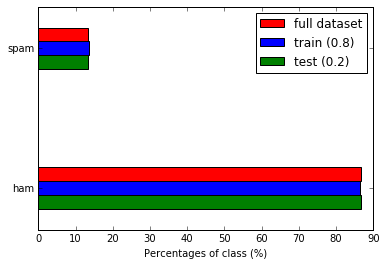

In [14]:
% matplotlib inline

percentages_of_class.plot.barh(color = 'red', label = 'full dataset', width = 0.1, position = -0.5)
percentages_of_class_train.plot.barh(color = 'blue', label = 'train (0.8)', width = 0.1, position = 0.5)
percentages_of_class_test.plot.barh(color = 'green', label = 'test (0.2)', width = 0.1, position = 1.5)
plt.xlabel('Percentages of class (%)')
plt.ylim([-0.3,1.3])
plt.legend()

##  Letter Case and Punctuation

Recall from the previous lesson that when a new message comes in, our Naive Bayes algorithm will make the classification based on the results it gets to these two equations (note that we replaced "SpamC" with "Ham" inside the second equation below):

\begin{equation}
P(Spam | w_1,w_2, ..., w_n) \propto P(Spam) \cdot \prod_{i=1}^{n}P(w_i|Spam)
\end{equation}

\begin{equation}
P(Ham | w_1,w_2, ..., w_n) \propto P(Ham) \cdot \prod_{i=1}^{n}P(w_i|Ham)
\end{equation}

Also, to calculate P(wi|Spam) and P(wi|Ham) inside the formulas above, recall that we need to use these equations:

\begin{equation}
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}}
\end{equation}

\begin{equation}
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
\end{equation}

To make the calculations easier, we want bring the data to this format (the table below is a transformation of the table you see above):

![](https://dq-content.s3.amazonaws.com/433/cpgp_dataset_2.png)

About the transformation above, notice that:

* The SMS column doesn't exist anymore.
* Instead, the SMS column is replaced by a series of new columns, where each column represents a unique word from the vocabulary.
* Each row describes a single message. For instance, the first row corresponds to the message "SECRET PRIZE! CLAIM SECRET PRIZE NOW!!", and it has the values spam, 2, 2, 1, 1, 0, 0, 0, 0, 0. These values tell us that:
    - The message is spam.
    - The word "secret" occurs two times inside the message.
    - The word "prize" occurs two times inside the message.
    - The word "claim" occurs one time inside the message.
    - The word "now" occurs one time inside the message.
    - The words "coming", "to", "my", "party", and "winner" occur zero times inside the message.
* All words in the vocabulary are in lower case, so "SECRET" and "secret" come to be considered to be the same word.
* Punctuation is not taken into account anymore (for instance, we can't look at the table and conclude that the first message initially had three exclamation marks).

Let's begin the data cleaning process by removing the punctuation and bringing all the words to lower case.

In [15]:
# before
sms_spam_train['SMS'].sample(10, random_state = 1)

2012    U say leh... Of course nothing happen lar. Not...
3037    I want some cock! My hubby's away, I need a re...
2359    Just curious because my cuz asked what I was u...
4386    Hello! Just got here, st andrews-boy its a lon...
2743    Thanks for being there for me just to talk to ...
2515    R u saying i should re order the slippers cos ...
990     She.s find. I sent you an offline message to k...
3473    I am going to sao mu today. Will be done only ...
4389                             Shb b ok lor... Thanx...
372     Urgent UR awarded a complimentary trip to Euro...
Name: SMS, dtype: object

In [16]:
# after
sms_spam_train['SMS'] = sms_spam_train['SMS'].str.lower().str.replace(r'[\W]+', ' ')
sms_spam_train['SMS'].sample(10, random_state = 1)

2012    u say leh of course nothing happen lar not say...
3037    i want some cock my hubby s away i need a real...
2359    just curious because my cuz asked what i was u...
4386    hello just got here st andrews boy its a long ...
2743    thanks for being there for me just to talk to ...
2515    r u saying i should re order the slippers cos ...
990     she s find i sent you an offline message to kn...
3473    i am going to sao mu today will be done only a...
4389                                  shb b ok lor thanx 
372     urgent ur awarded a complimentary trip to euro...
Name: SMS, dtype: object

## Creating the Vocabulary

On the previous screen, we removed the punctuation and changed all letters to lowercase. Recall that our end goal with this data cleaning process is to bring our training set to this format:

![](https://dq-content.s3.amazonaws.com/433/cpgp_dataset_3.png)

With the exception of the "Label" column, every other column in the transformed table above represents a unique word in our vocabulary (more specifically, each column shows the frequency of that unique word for any given message). Recall from the previous lesson that we call the set of unique words a vocabulary.

We'll eventually bring the training set to that format ourselves, but first, let's create a list with all of the unique words that occur in the messages of our training set.

In [17]:
sms_spam_train['SMS'] = sms_spam_train['SMS'].str.split()
sms_spam_train['SMS'].head()

0                    [yep, by, the, pretty, sculpture]
1    [yes, princess, are, you, going, to, make, me,...
2                      [welp, apparently, he, retired]
3                                             [havent]
4    [i, forgot, 2, ask, ü, all, smth, there, s, a,...
Name: SMS, dtype: object

In [18]:
vocabulary = []

for words in sms_spam_train['SMS']:
    for word in words:
        
        if word not in vocabulary: vocabulary.append(word)

In [19]:
len(vocabulary)

7783

In [20]:
vocabulary[:10]

['yep',
 'by',
 'the',
 'pretty',
 'sculpture',
 'yes',
 'princess',
 'are',
 'you',
 'going']

## The Final Training Set

In [21]:
word_counts_per_sms = {}

for word in vocabulary:
    word_counts_per_sms[word] = [0]*sms_spam_train.shape[0]

len(word_counts_per_sms['yes'])

4458

In [22]:
for i, sms in enumerate(sms_spam_train['SMS']):
    for word in sms:
        word_counts_per_sms[word][i] += 1

In [23]:
word_counts_per_sms['yes'][:10]

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [24]:
word_counts_df = pd.DataFrame(word_counts_per_sms)
word_counts_df.iloc[0:5, 0:5]

,0,00,000,000pes,008704050406
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [25]:
sms_spam_train_cleaned = pd.concat([sms_spam_train, word_counts_df], axis = 1)
sms_spam_train_cleaned.head()

,Label,SMS,0,00,000,000pes,008704050406,0089,01223585334,02,...,zindgi,zoe,zogtorius,zouk,zyada,é,ú1,ü,〨ud,鈥
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0


##  Calculating Constants First

In [26]:
p_ham = sms_spam_train_cleaned['Label'].value_counts(normalize = True)['ham']
p_spam = sms_spam_train_cleaned['Label'].value_counts(normalize = True)['spam']

In [27]:
p_ham, p_spam

(0.8654104979811574, 0.13458950201884254)

In [28]:
spam = sms_spam_train_cleaned[sms_spam_train_cleaned.Label == 'spam']
ham = sms_spam_train_cleaned[sms_spam_train_cleaned.Label == 'ham']

In [29]:
n_spam = spam['SMS'].apply(len).sum()
n_ham = ham['SMS'].apply(len).sum()

n_ham, n_spam

(57237, 15190)

In [30]:
n_vocabulary = len(vocabulary)
n_vocabulary

7783

In [31]:
alpha = 1

## Calculating Parameters

Let's now calculate all the parameters using the equations below:

\begin{equation}
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}}
\end{equation}

\begin{equation}
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
\end{equation}

In [32]:
p_given_spam = {}
p_given_ham = {}

for word in vocabulary:
    
    n_word_spam = spam[word].sum()
    n_word_ham = ham[word].sum()
    
    p_word_given_spam = (n_word_spam + alpha)/(n_spam + alpha*n_vocabulary)
    p_word_given_ham = (n_word_ham + alpha)/(n_ham + alpha*n_vocabulary)
    
    p_given_spam[word] = p_word_given_spam
    p_given_ham[word] = p_word_given_ham    

In [33]:
p_given_ham['yep'], p_given_spam['yep']

(0.00015379883112888343, 4.3529360553693465e-05)

## Classifying A New Message

In [34]:
import re

def classify(message, p_spam, p_ham, p_given_spam, p_given_ham):

    message = re.sub(r'[\W]+', ' ', message)
    message = message.lower()
    message = message.split()
    
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    vocabulary = p_given_spam.keys()
    
    for word in message:
        
        if word not in vocabulary:
            continue
        
        p_spam_given_message *= p_given_spam[word]
        p_ham_given_message *= p_given_ham[word]


    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

In [35]:
test_sms = ['WINNER!! This is the secret code to unlock the money: C3421.', "Sounds good, Tom, then see u there"]

In [36]:
classify(test_sms[0], p_spam = p_spam, p_ham = p_ham, p_given_spam = p_given_spam, p_given_ham = p_given_ham)

P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.9368049028589875e-27
Label: Spam


In [37]:
classify(test_sms[1], p_spam = p_spam, p_ham = p_ham, p_given_spam = p_given_spam, p_given_ham = p_given_ham)

P(Spam|message): 2.4372375665888117e-25
P(Ham|message): 3.687530435009238e-21
Label: Ham


## Measuring the Spam Filter's Accuracy

In [38]:
# Build the classifier without printout

def classify_spam_NB(message, p_spam, p_ham, p_given_spam, p_given_ham):

    message = re.sub(r'[\W]+', ' ', message)
    message = message.lower()
    message = message.split()
    
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    vocabulary = p_given_spam.keys()
    
    for word in message:
        
        if word not in vocabulary:
            continue
        
        p_spam_given_message *= p_given_spam[word]
        p_ham_given_message *= p_given_ham[word]

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    else:
        return 'human classification needed'

In [39]:
# test our classifier with the test data

sms_spam_test['NB_Label'] = sms_spam_test['SMS'].apply(classify_spam_NB, 
                                                       p_spam = p_spam, p_ham = p_ham, 
                                                       p_given_spam = p_given_spam, p_given_ham = p_given_ham)

sms_spam_test.head()

,Label,SMS,NB_Label
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


In [40]:
correct_pred = sms_spam_test['Label'] == sms_spam_test['NB_Label']
accuracy = correct_pred.mean()

print('Our Naive Bayesian Classifier for spam detection results in an accuracy of {:.2%}.'.format(accuracy))

Our Naive Bayesian Classifier for spam detection results in an accuracy of 98.74%.
